<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_runtime_sample_00_mkbahk_20241007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.1.0

## Qiskit 설치: Mac 또는 Linux ###
#%pip install 'qiskit[visualization]'==1.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.0.2
    Uninstalling qiskit-1.0.2:
      Successfully uninstalled qiskit-1.0.2


In [2]:
### 다른 패키지들도 설치해봅시다
%pip install qiskit_aer
#%pip install qiskit_ibm_runtime
%pip install matplotlib
%pip install pylatexenc
%pip install qiskit-transpiler-service

In [4]:
### Qiskit 버전을 확인합니다
import qiskit
qiskit.__version__

'1.1.0'

In [5]:
### 다른 패키지들의 버전을 확인합니다
%pip show qiskit qiskit-ibm-runtime qiskit_aer qiskit-transpiler-service pylatexenc matplotlib

Name: qiskit
Version: 1.1.0
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime, qiskit-qasm3-import, qiskit-transpiler-service
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-aer
Version: 0.15.1

In [6]:
# API 토큰을 등록하여 진도를 추적할 수 있도록 합니다

%set_env QXToken=5782db17accbfbdc8aed8f5d0a493e4f841eda586140dd0f31b4126bc87597ef34bb35b9f39cada6e496a02328463bc514c83a62de5df3653e2c55e1d495f14e

# 등호 앞뒤에 공백이 없도록 주의해주세요


env: QXToken=5782db17accbfbdc8aed8f5d0a493e4f841eda586140dd0f31b4126bc87597ef34bb35b9f39cada6e496a02328463bc514c83a62de5df3653e2c55e1d495f14e


In [7]:
### 불러오기
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

Qiskit pattern은 양자컴퓨팅을 수행하는 4단계의 워크플로우를 의미합니다. 이 워크플로우는 유용한 단계(utility-scale)의 양자컴퓨터를 사용하는 것을 돕기 위해 설계되었습니다. 이는 다음과 같은 순서로 진행됩니다:

    회로와 연산자 정의하기
    회로 최적화하기
    회로 실행하기
    결괏값 후처리



##1단계: 회로와 연산자 정의하기

주어진 문제에서 양자 회로와 연산자를 정의하는 것은 큐비트의 개수가 적을 때는 사실 간단한 일입니다. 하지만 스케일이 커지게 된다면 상황이 달라질 수 있습니다. 지금은 간단하게 2-큐비트의 Bell state를 만들어보겠습니다. 이것은 고전적인... 아니 그럼에도 "양자적인" 예시로, 두 개의 큐비트 사이의 양자 얽힘을 보여줄 수 있는 상태입니다.

첫 번째로, 0번 큐비트에 Hadamard 게이트를 가해 중첩 상태를 만듭니다. 그리고는 0번 큐비트에서 1번 큐비트로 CNOT 게이트를 가합니다. 이 CNOT 게이트는 실질적으로 큐비트의 얽힘을 만들어내게 되며, 이로 인해 이 회로의 측정값에서 두 큐비트의 관측 결과 사이에 어떠한 규칙이 공유되고 있는 것을 볼 수 있게 됩니다.

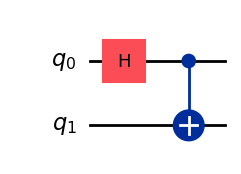

In [8]:
from qiskit import QuantumCircuit

# 1-큐비트 회로를 생성합니다
qc = QuantumCircuit(2)

# 0번 큐비트에 Not 게이트를 가합니다
qc.h(0)
qc.cx(0, 1)
# MatPlotLib("mpl")을 사용해 회로를 그립니다.
# 이것이 셀의 마지막에 위치하기 때문에 셀의 output으로 이미지를 볼 수 있습니다.
qc.draw("mpl")


다음은 이 회로가 예상한대로 동작하고 있는지를 확인해보겠습니다. 이를 수행하기 위해서는 연산자를 정의해야 합니다.

두 개의 큐비트에 맞는 연산자를 만들어봅시다. XX와 같은 어떤 연산자는 두 큐비트를 모두 관측하기도 하고, XI와 같은 어떤 연산자는 하나만을 관측하기도 합니다. 이 다음에는 이 연산자들의 기댓값을 확인하여 만들어진 회로가 잘 작동하고 있는지 확인할 것입니다. 만들어진 상태가 Bell state이기 때문에 하나의 큐비트를 관측하여 얻게 되는 모든 기댓값은 0이 될 것이라고 예측할 수 있습니다. 비슷한 이유로, 두 개의 큐비트를 모두 관측하는 연산자의 기댓값은 0이 아닌 어떤 값을 줄 것으로 예측할 수 있겠죠. (아마도 1에 가까울 것입니다.)

그렇다면 연산자는 어떻게 정의해야 할까요? 이것은 간단하게 X, Y, Z와 Identity (I) 연산자를 조합해 정의할 수 있습니다.

    큐비트에 I 게이트를 가하는 것은 큐비트에 아무것도 하지 않는 것과 같습니다. X/Z와 I 연산자를 조합하여 XI, IX, ZI, 그리고 IZ 연산자를 만들 수 있습니다.
    2-큐비트 연산자로는 XX와 ZZ 두 개의 연산자만 만들면 됩니다. 각각 X와 Z 연산자의 조합으로 만들 수 있습니다.

이 lab의 뒷부분에서 각 연산자의 기댓값을 그래프로 나타낼 것입니다.


In [10]:
# The ZZ applies a Z operator on qubit 0, and a Z operator on qubit 1
ZZ = SparsePauliOp('ZZ')

# The ZI applies a Z operator on qubit 0, and an Identity operator on qubit 1
ZI = SparsePauliOp('ZI')

# The IX applies an Identity operator on qubit 0, and an X operator on qubit 1
IX = SparsePauliOp('IX')



### Write your code below here ###
### Follow the same naming convention we used above


### SOLUTION
IZ = SparsePauliOp('IZ')
XX = SparsePauliOp('XX')
XI = SparsePauliOp('XI')



## Don't change any code past this line, but remember to run the cell.

observables = [IZ, IX, ZI, XI, ZZ, XX]


##2단계: 회로 최적화하기

Qiskit pattern은 유용한 단계(utility scale)의 양자컴퓨터에 최적화된 프레임워크입니다. 여기서 유용한 단계(utility scale)란 양자컴퓨터가 고전컴퓨터보다 더 신뢰성 있는 계산을 수행할 수 있는 단계를 말합니다. 이러한 계산에서는 일반적으로 수백개의 큐비트를 사용하게 됩니다. 그러나 이번 lab에서 사용하는 큐비트의 개수는 두 개밖에 되지 않습니다. 따라서 지금은 회로를 최적화하기 위해 특별히 무언가를 할 필요가 없는 것이죠.

회로를 최적화하기 위해서는 Qiskit transpiler를 사용할 수 있습니다. Transpile을 수행할 때에는 필요한 게이트의 숫자를 줄이기 위해 큐비트의 배치를 최적화하는 등의 작업을 수행하게 됩니다. 이 단계에 대해서는 이후의 lab에서 다룰 예정이므로, 지금은 우선 pattern의 다음 단계로 넘어가보도록 하겠습니다.

##3단계: 회로 실행하기

이제 회로를 실행할 시간입니다.

다음 셀에서는 새로운 라이브러리를 사용하게 됩니다. 바로 Qiskit Runtime을 사용해 회로를 실행하는 것이죠.

다음 lab 1에서 Qiskit Runtime과 Primitive에 대해서 더 자세하게 다룰 예정입니다. 따라서 지금은 Qiskit Runtime이 양자 회로를 실행하는 가장 쉬운 방법이라는 점만 말씀드리도록 하겠습니다.

여기서는 Estimator를 사용해 회로를 실행할 것이며, 실행 결과를 job 변수에 저장할 것입니다. 이 셀을 실행하고 나면 Qiskit pattern의 마지막 단계로 넘어가 이 정보를 시각화할 수 있게 됩니다.


In [12]:
# Estimator를 설정합니다
#estimator = Estimator(backend=AerSimulator())
estimator = Estimator(AerSimulator())
# Estimator로 회로를 실행합니다
pub = (qc, observables)

job = estimator.run(pubs=[pub])


##4단계: 결과값 후처리

Qiskit pattern의 마지막 단계는 양자 회로의 실행 결과를 처리하고, 분석하고, 시각화하는 단계입니다.

이것을 수행하는 데에는 여러 가지 방법이 있습니다. IBM Quantum Challenge에서는 이 단계를 수행하는 다양한 방법들을 보여드릴 예정입니다. 새로운 것을 배우는 것은 항상 즐거우니까요!

여기서는 데이터를 수집하고 그래프로 나타내는 작업을 해보겠습니다.


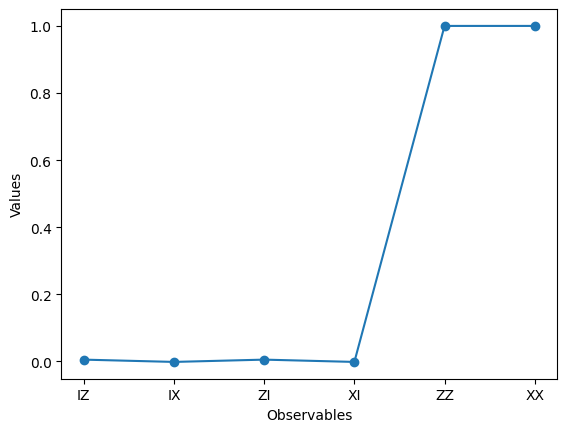

In [13]:
# Collect the data
data = ['IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XX']
values = job.result()[0].data.evs

# Set up our graph
container = plt.plot(data, values, '-o')

# Label each axis
plt.xlabel('Observables')
plt.ylabel('Values')

# Draw the final graph
plt.show()


출력된 그래프에서 두 큐비트를 모두 측정하는 ZZ와 XX의 측정값은 1에, 다른 연산자의 측정값은 0에 가까워야 합니다. 이것은 이 상태가 얽힘 상태에 있다는 것을 보여줍니다. 잘 하셨습니다.

현재 그래프는 선형으로 출력되고 있지만, 같은 데이터를 막대 그래프로도 시각화할 수 있습니다.


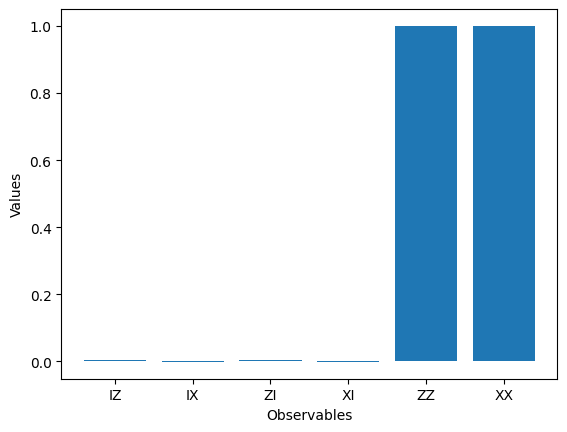

In [14]:
container = plt.bar(data, values, width=0.8)

plt.xlabel('Observables')
plt.ylabel('Values')

plt.show()